[Ссылка на исходный блокнот](https://github.com/facebookresearch/sam3/blob/main/examples/sam3_image_predictor_example.ipynb)

In [1]:
from IPython.display import clear_output

In [10]:
!pip install modelscope
clear_output()

In [11]:
!modelscope download --model facebook/sam3
clear_output()

In [12]:
!pip install decord
clear_output()

In [13]:
!git clone https://github.com/facebookresearch/sam3.git

fatal: destination path 'sam3' already exists and is not an empty directory.


In [2]:
!cd /content/sam3 && pip install -e . && pip install -e ".[notebooks]"
clear_output()

In [ ]:
# После установки зависимостей нужно перезапустить сеанс

In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126
CUDA is available: True


In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np

import sam3
from PIL import Image
from sam3.model_builder import build_sam3_image_model
from sam3.model.box_ops import box_xywh_to_cxcywh
from sam3.model.sam3_image_processor import Sam3Processor
from sam3.visualization_utils import draw_box_on_image, normalize_bbox, plot_results


sam3_root = "/content/sam3"

In [3]:
import torch

# turn on tfloat32 for Ampere GPUs
# https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [4]:
%cd /content/sam3/assets/

/content/sam3/assets


In [5]:
!wget https://dl.fbaipublicfiles.com/mmf/clip/bpe_simple_vocab_16e6.txt.gz

--2025-12-25 17:10:41--  https://dl.fbaipublicfiles.com/mmf/clip/bpe_simple_vocab_16e6.txt.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 65.8.76.47, 65.8.76.35, 65.8.76.77, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|65.8.76.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1356917 (1.3M) [application/gzip]
Saving to: ‘bpe_simple_vocab_16e6.txt.gz.1’

bpe_simple_vocab_16 100%[===================>]   1.29M  --.-KB/s    in 0.009s  

2025-12-25 17:10:41 (138 MB/s) - ‘bpe_simple_vocab_16e6.txt.gz.1’ saved [1356917/1356917]



# Build Model

In [6]:
bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"
model = build_sam3_image_model(bpe_path=bpe_path, checkpoint_path="/root/.cache/modelscope/hub/models/facebook/sam3/sam3.pt")

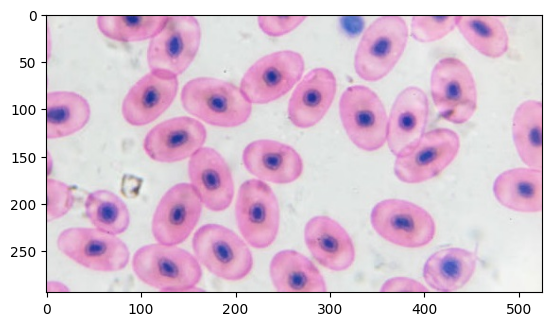

In [7]:
image_path = "/content/1.jpg"

image = Image.open(image_path)
width, height = image.size
processor = Sam3Processor(model, confidence_threshold=0.5)
inference_state = processor.set_image(image)

plt.imshow(image)
plt.show()

# Text prompt

found 62 object(s)


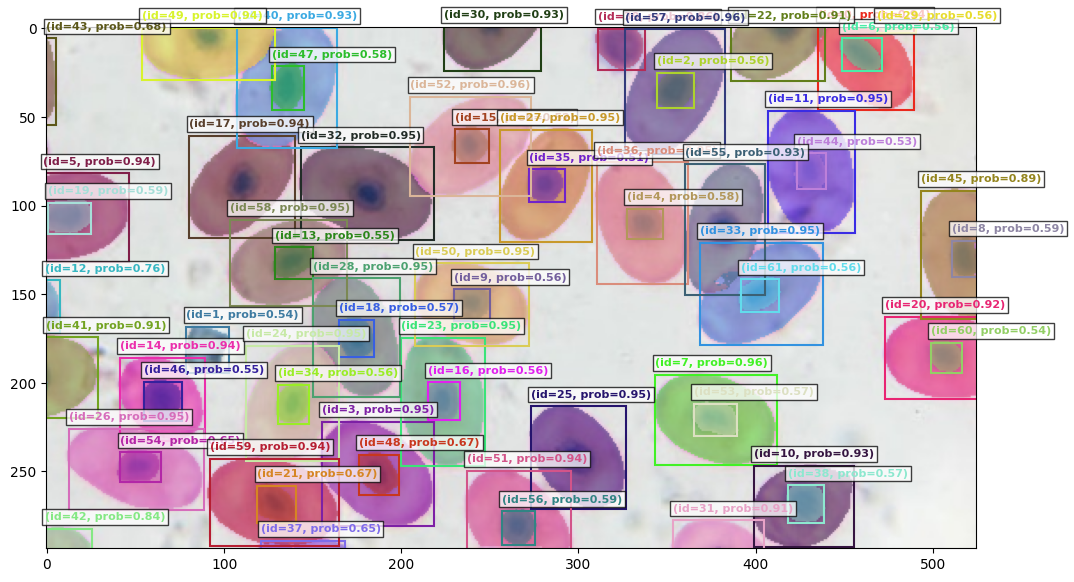

In [8]:
processor.reset_all_prompts(inference_state)
inference_state = processor.set_text_prompt(state=inference_state, prompt="cell")

img0 = Image.open(image_path)
plot_results(img0, inference_state)

found 37 object(s)


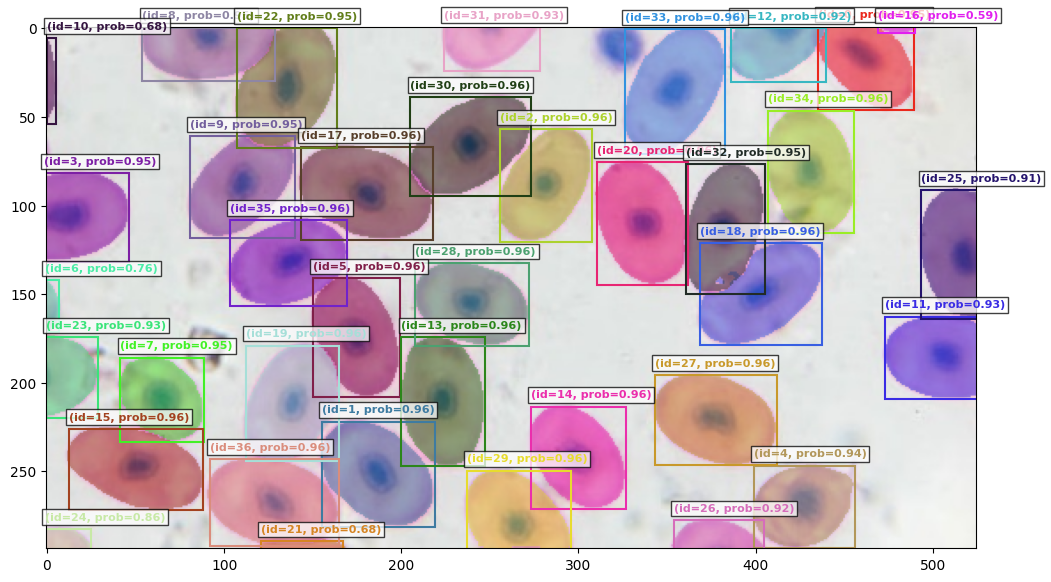

In [9]:
processor.reset_all_prompts(inference_state)
inference_state = processor.set_text_prompt(state=inference_state, prompt="pink cell")

img0 = Image.open(image_path)
plot_results(img0, inference_state)

found 32 object(s)


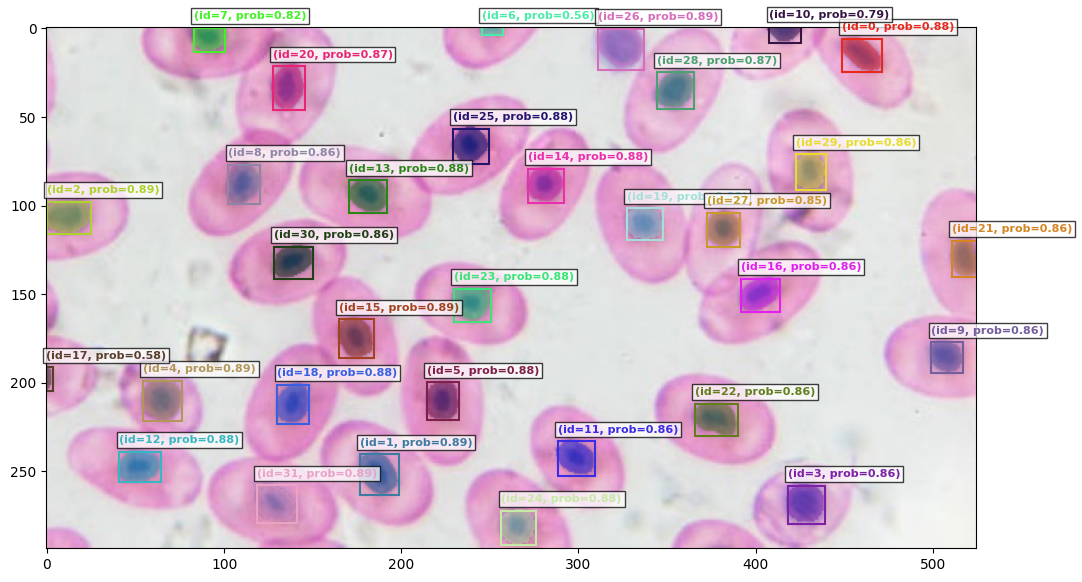

In [10]:
processor.reset_all_prompts(inference_state)
inference_state = processor.set_text_prompt(state=inference_state, prompt="blue cell")

img0 = Image.open(image_path)
plot_results(img0, inference_state)

## Visual prompt: a single bounding box

Normalized box input: [0.4557810425758362, 0.2277858704328537, 0.12992018461227417, 0.19127176702022552]


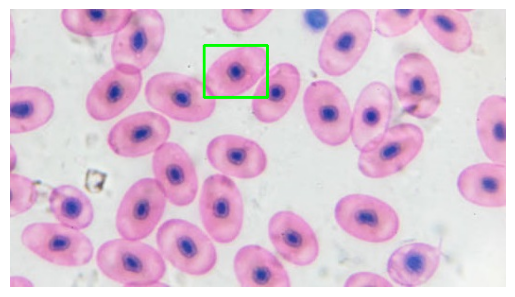

In [11]:
# Here the box is in  (x,y,w,h) format, where (x,y) is the top left corner.
box_input_xywh = torch.tensor([205.1810, 38.8521, 68.2081, 56.2339]).view(-1, 4)
box_input_cxcywh = box_xywh_to_cxcywh(box_input_xywh)

norm_box_cxcywh = normalize_bbox(box_input_cxcywh, width, height).flatten().tolist()
print("Normalized box input:", norm_box_cxcywh)

processor.reset_all_prompts(inference_state)
inference_state = processor.add_geometric_prompt(
    state=inference_state, box=norm_box_cxcywh, label=True
)

img0 = Image.open(image_path)
image_with_box = draw_box_on_image(img0, box_input_xywh.flatten().tolist())
plt.imshow(image_with_box)
plt.axis("off")
plt.show()

found 38 object(s)


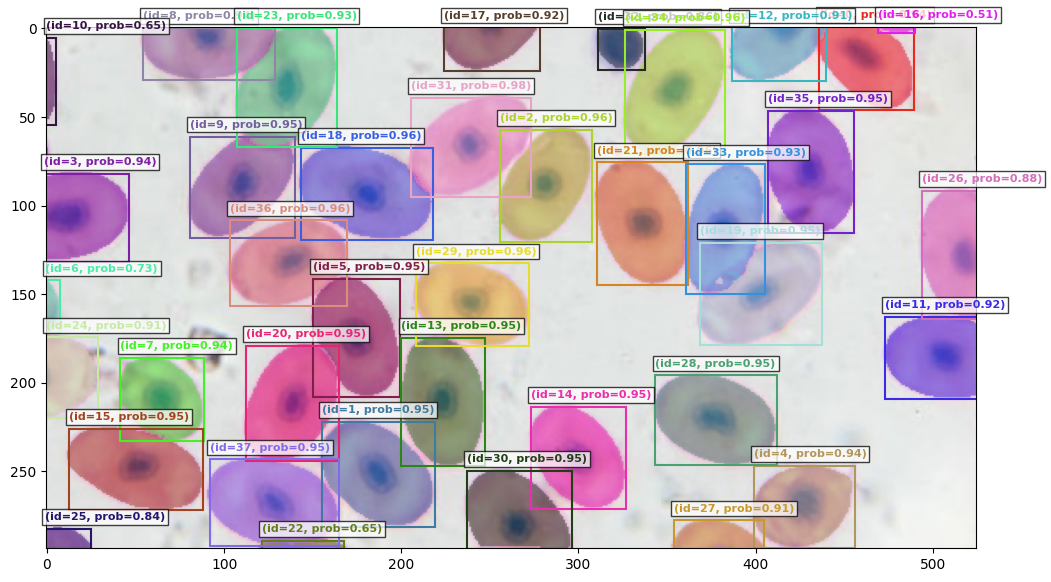

In [12]:
plot_results(img0, inference_state)